# <i class="fas fa-star"></i>&hairsp;T05: Visualizing Reconstructions in Napari

This tutorial demonstrates how to use pysnt to render and interact with neuronal reconstructions in [napari](https://napari.org/), the multi-dimensional image viewer for Python. Basic familiarity with napari is helpful but not required.


```{hint}
By the end of this notebook, you will be able to:
- Load and visualize neuronal reconstructions in napari with accurate 3D geometry
- Render trees as surface meshes with proper diameter information
- Render images and color mappings to highlight morphological features

**Estimated Time**: 15-20 minutes
```

```{note}
Make sure to read [Tutorial 01](./01_single_cell_analysis.ipynb) before running this notebook.

```

```{warning}
**Extra Requirements:** This tutorial requires [napari](https://napari.org/):

```bash
mamba activate pysnt
mamba install napari pyqt
```

## Checking Requirements

We'll start first by making sure all of the required dependencies have been installed:

In [1]:
# Check if napari and pysnt are properly installed
try:
    import napari
    print(f"napari {napari.__version__} available!")
except ImportError:
    print("Napari is not available: Notebook will not run!")
try:
    import pysnt
    print(f"pysnt {pysnt.version()} available!")
except ImportError:
    print("PySNT is not available: Notebook will not run!")

napari 0.6.6 available!
pysnt 0.0.1 available!


If you are having problems, you may want to use a dedicated environment with known-to-work dependencies:

```bash
# Create new environment with a known Python version supported by Napari
mamba create -n pysnt-napari python=3.12 napari pyqt openjdk=21

# Activate it
mamba activate pysnt-napari

# Install pysnt in this environment
cd ../pysnt # path to downloaded copy of pysnt source code
pip install -e .
```

## Loading Reconstructions

We will use one of SNT's demo datasets using {class}`pysnt.SNTService`. Let's load the *OP_1* cell from the [DIADEM challenge](https://diadem.janelia.org/challenge.html):

In [16]:
import pysnt

# Initialize PySNT
pysnt.initialize('headless') # same as pysnt.initialize(), or pysnt.initialize(mode='headless')

snt_service = pysnt.SNTService()
tree = snt_service.demoTree('OP1')

```{hint}
See [Tutorial 01](./01_single_cell_analysis.ipynb) for pointers on how to load local files.
```

## Visualizing Centerlines: Shapes Layer

This is the most straightforward way to visualize tracings in napari: Render each path as a centerline with a single color:

```{warning}
Note that while SNT uses XYZ coordinates, napari uses ZYX ordering.
```

2025-12-03 20:09:41.143 python[33505:17290997] [JRSAppKitAWT markAppIsDaemon]: Process manager already initialized: can't fully enable headless mode.


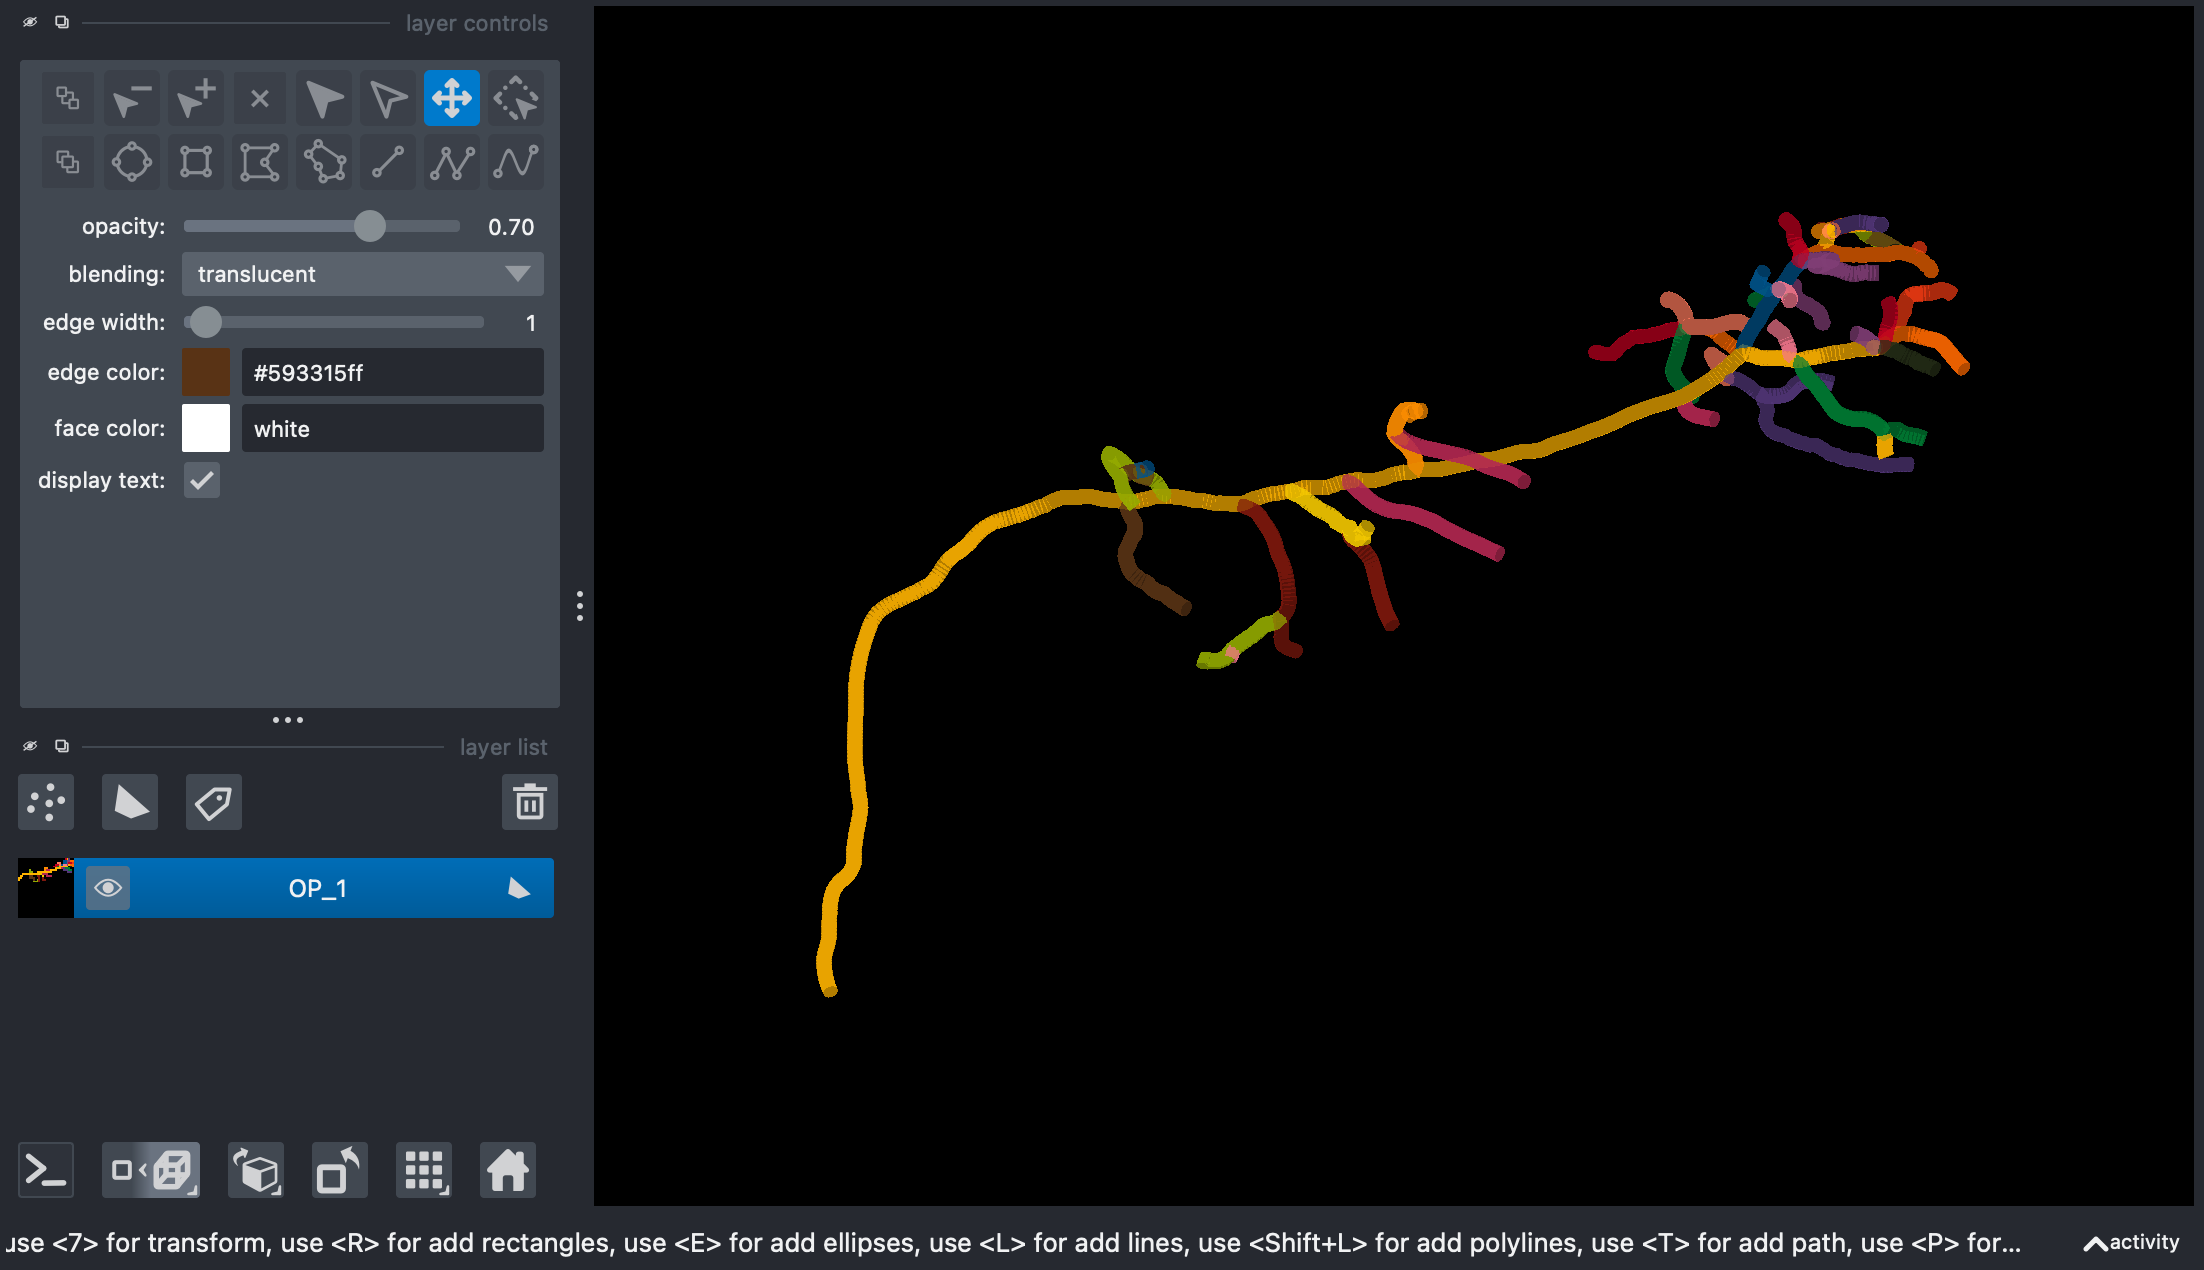

In [3]:
import numpy as np
import napari
from napari.utils import nbscreenshot

def tree_to_napari_paths(tree):
    """Convert SNT Tree paths to napari-compatible format."""
    paths_data = []
    
    for path in tree.list():
        coords = []
        for i in range(path.size()):
            node = path.getNode(i)
            # IMPORTANT: napari uses ZYX order, SNT uses XYZ
            coords.append([node.z, node.y, node.x])

        if len(coords) > 1:
            paths_data.append(np.array(coords))
    
    return paths_data

# Get demo tree and convert to napari paths
paths = tree_to_napari_paths(tree)

# Assign distinct colors to each path: We can use SNT's contrast
# colors as hex strings, as long as we remove the alpha channel
# (last 2 characters) from each hex string.
from pysnt.util import SNTColor
path_colors = SNTColor.getDistinctColorsHex(len(paths), 'dim') # Skip dim hues
path_colors = [color[:-2] for color in path_colors]

# Create viewer without showing window
viewer = napari.Viewer(show=False)
viewer.dims.ndisplay = 3 # set 3D view

# Add all paths to a single napari layer
paths_layer = viewer.add_shapes(
    paths,
    shape_type='path',
    edge_color=path_colors,
    edge_width=1,
    name=tree.getLabel(),
)

# Take a snapshot of the scene
nbscreenshot(viewer)

We can use a 'zoom to fit' utility function to ensure all paths are visible:

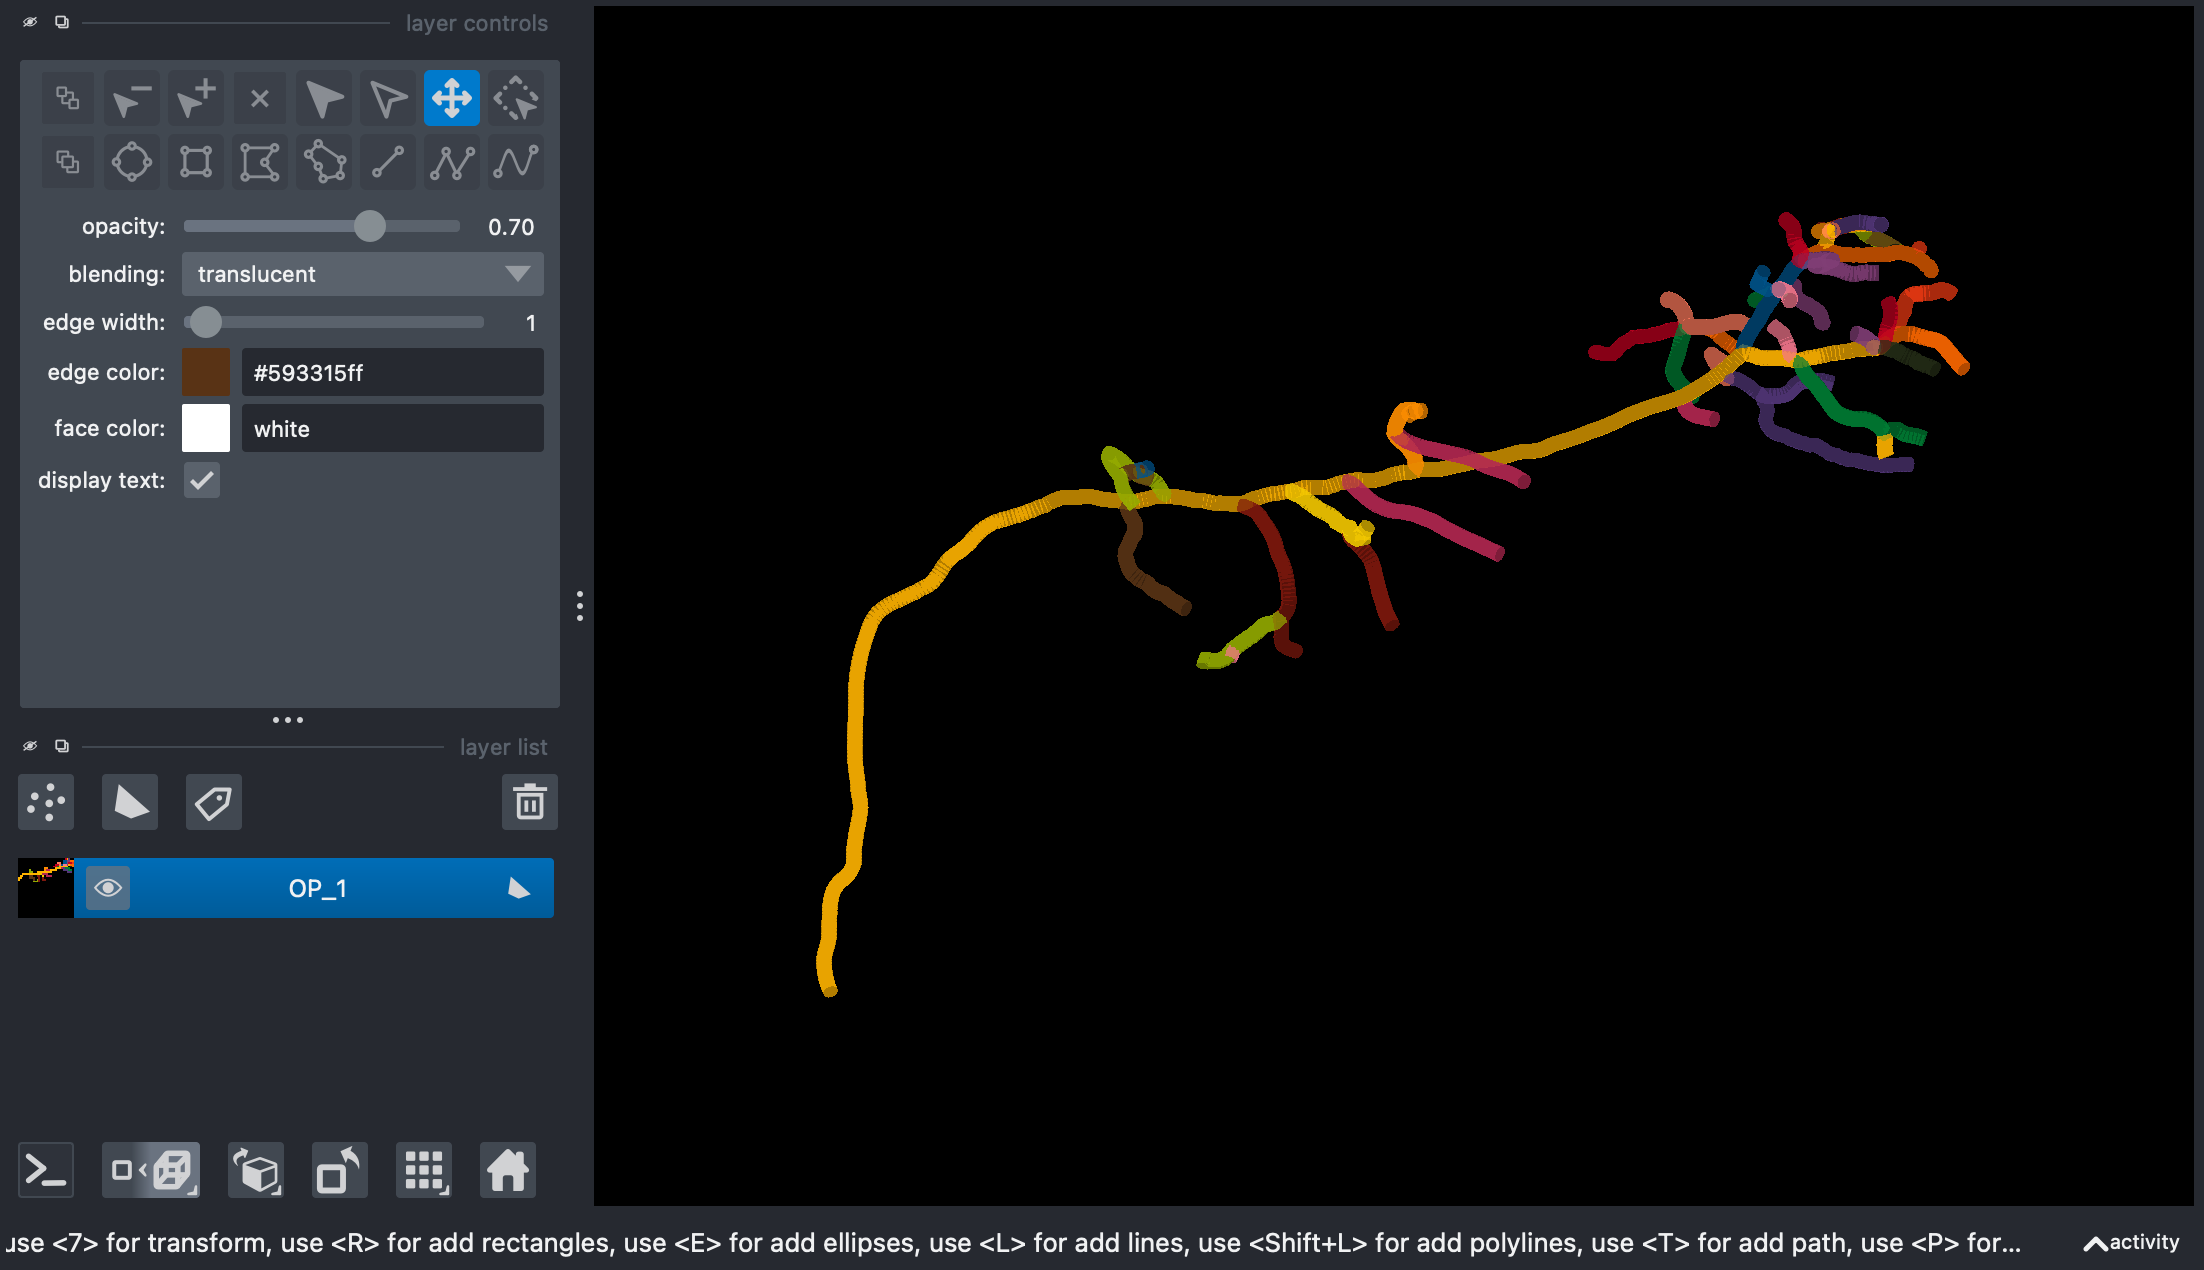

In [4]:
def zoom_to_layer(viewer, layer, fov_adjust=1):
    """Zoom to fit a layer in the viewer."""
    # Get the bounding box of the layer
    extent = layer.extent

    # Calculate center and range
    data_range = extent.data[1] - extent.data[0]  # [z_range, y_range, x_range]
    center = (extent.data[0] + extent.data[1]) / 2

    # Set camera center
    viewer.camera.center = center


# Take a snapshot of the scene
zoom_to_layer(viewer, paths_layer)
nbscreenshot(viewer)

## Visualizing Nodes: Points Layer

The _paths_ layer doesn't support variable width along a path. For rendering local thicknesses, the simplest (but least accurate) strategy is to render each node as a sphere:

Radii range: 0.099884 to 1.539689
NaN or inf radii: False


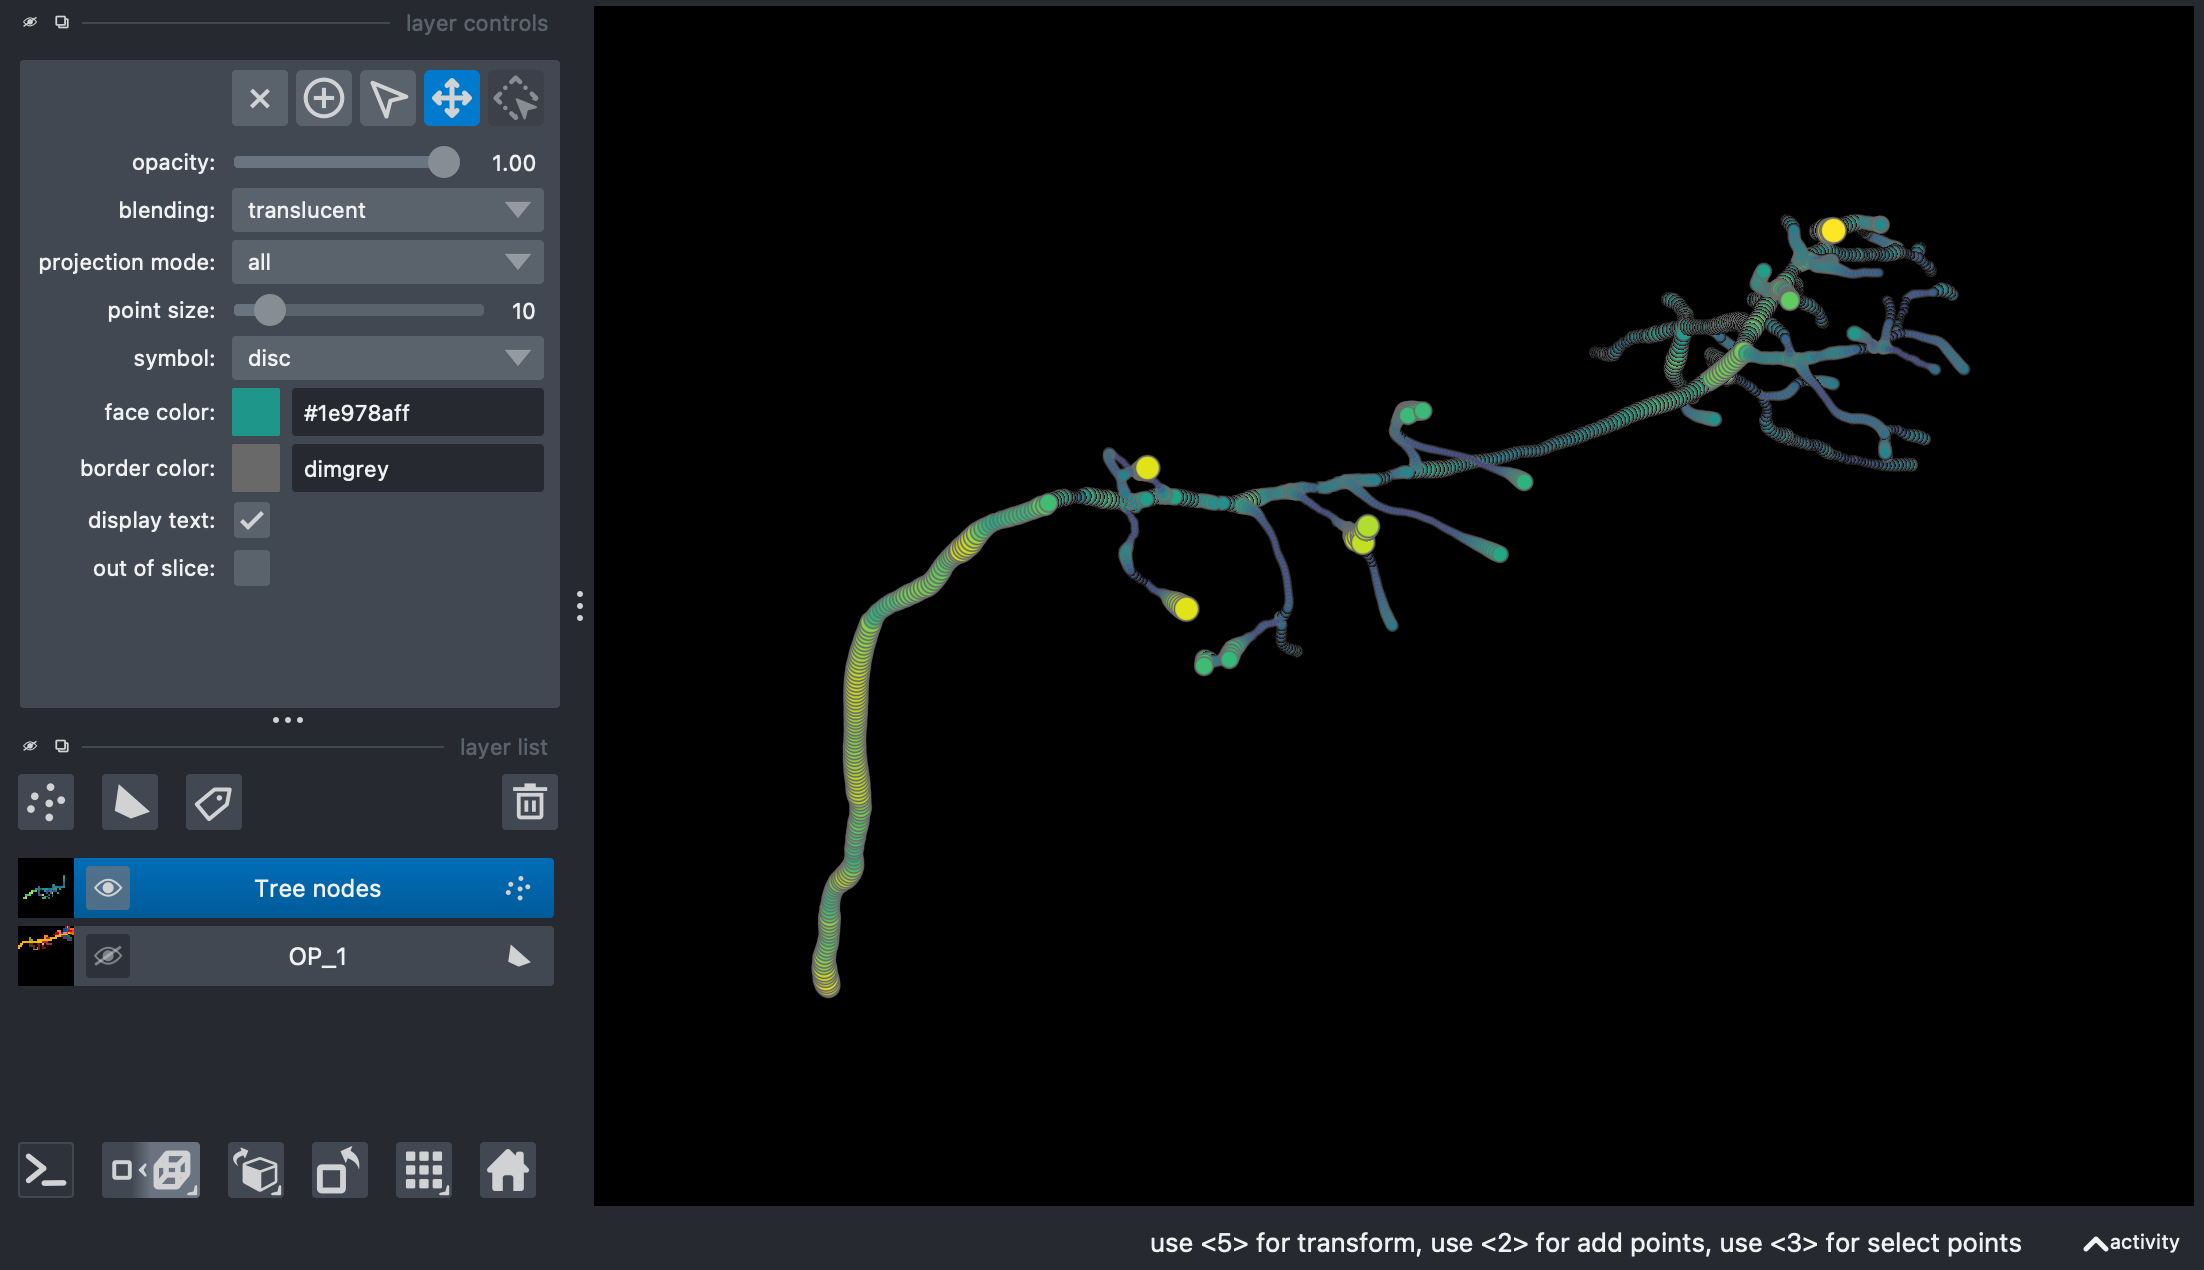

In [5]:
def tree_to_points_with_size(tree):
    """Convert tree nodes to points with size based on radius."""
    coords = []
    radii = []
    
    for path in tree.list():
        for i in range(path.size()):
            node = path.getNode(i)
            coords.append([node.z, node.y, node.x])
            radii.append(node.radius)
    
    return np.array(coords), np.array(radii)

coords, radii = tree_to_points_with_size(tree)

# Check for any invalid values
print(f"Radii range: {radii.min()} to {radii.max()}")
print(f"NaN or inf radii: {np.any(~np.isfinite(radii) & (radii > 0))}")

# This reconstruction does not have invalid radii, but absent values
# are quite common, so we can filter out any invalid values if needed
valid_mask = np.isfinite(radii) & (radii > 0)
coords = coords[valid_mask]
radii = radii[valid_mask]

nodes_layer = viewer.add_points(
    coords, 
    size=[r * 2 for r in radii],
    features={'radii': radii},  # Store radii as a feature
    face_color='radii',  # Color by the radius feature
    face_colormap='viridis',
    name='Tree nodes'
)

napari.run()

paths_layer.visible = False
nbscreenshot(viewer)

In [6]:
from napari.layers import Surface

def create_cylinder_mesh(p1, p2, r1, r2, n_segments=8):
    """Create a truncated cone mesh between two points with different radii."""
    # Calculate direction vector
    direction = p2 - p1
    length = np.linalg.norm(direction)
    if length == 0:
        return None, None
    
    direction = direction / length
    
    # Create perpendicular vectors
    if abs(direction[2]) < 0.9:
        perp1 = np.cross(direction, [0, 0, 1])
    else:
        perp1 = np.cross(direction, [1, 0, 0])
    perp1 = perp1 / np.linalg.norm(perp1)
    perp2 = np.cross(direction, perp1)
    
    # Create circle vertices at both ends
    angles = np.linspace(0, 2*np.pi, n_segments, endpoint=False)
    vertices = []
    
    for i, (point, radius) in enumerate([(p1, r1), (p2, r2)]):
        for angle in angles:
            offset = radius * (np.cos(angle) * perp1 + np.sin(angle) * perp2)
            vertices.append(point + offset)
    
    vertices = np.array(vertices)
    
    # Create faces connecting the two circles
    faces = []
    for i in range(n_segments):
        next_i = (i + 1) % n_segments
        # Two triangles per segment
        faces.append([i, next_i, i + n_segments])
        faces.append([next_i, next_i + n_segments, i + n_segments])
    
    return vertices, np.array(faces)

def tree_to_surface(tree):
    """Convert SNT Tree to surface mesh with proper diameters."""
    all_vertices = []
    all_faces = []
    vertex_offset = 0
    
    for path in tree.list():
        for i in range(path.size() - 1):
            node1 = path.getNode(i)
            node2 = path.getNode(i + 1)
            
            p1 = np.array([node1.z, node1.y, node1.x])
            p2 = np.array([node2.z, node2.y, node2.x])
            r1 = node1.radius
            r2 = node2.radius
            
            verts, faces = create_cylinder_mesh(p1, p2, r1, r2)
            if verts is not None:
                all_vertices.append(verts)
                all_faces.append(faces + vertex_offset)
                vertex_offset += len(verts)
    
    if not all_vertices:
        return None, None
    
    return (np.vstack(all_vertices), np.vstack(all_faces))

vertices, faces = tree_to_surface(tree)

surface_layer = viewer.add_surface(
    (vertices, faces),
    colormap='green',
    name=f'{tree.getLabel()} (surface)'
)

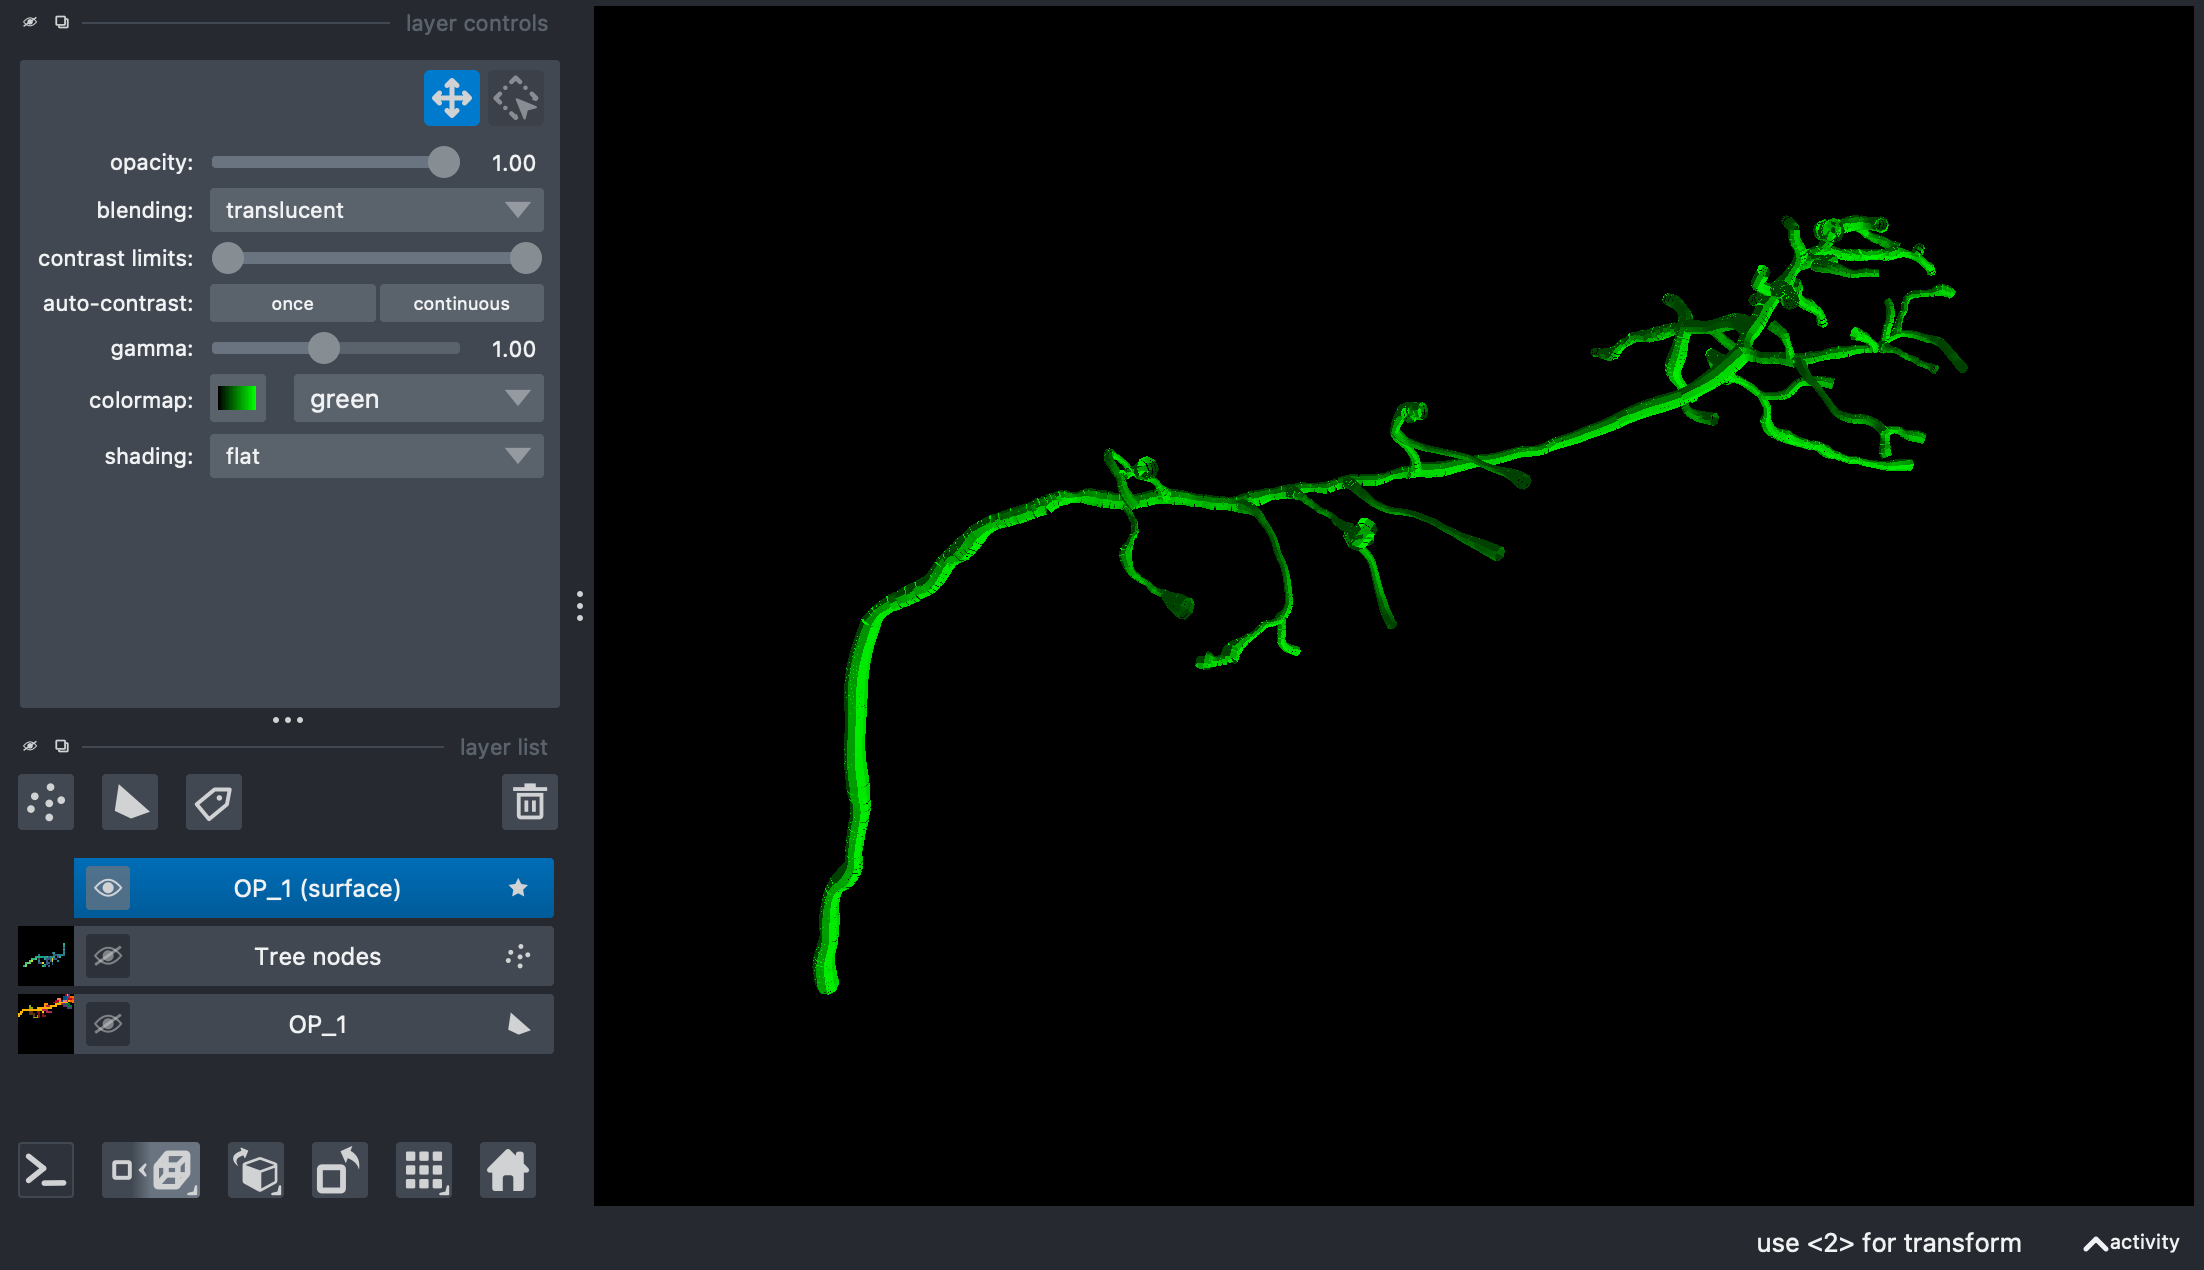

In [7]:
paths_layer.visible = False
nodes_layer.visible = False
nbscreenshot(viewer)

We can modify the functions so that we can color-code sections by their thickness, as we've done earlier with the Points layer:

In [8]:
def create_cylinder_mesh(p1, p2, r1, r2, n_segments=8):
    """Create a truncated cone mesh between two points with different radii."""
    # Calculate direction vector
    direction = p2 - p1
    length = np.linalg.norm(direction)
    if length == 0:
        return None, None, None
    
    direction = direction / length
    
    # Create perpendicular vectors
    if abs(direction[2]) < 0.9:
        perp1 = np.cross(direction, [0, 0, 1])
    else:
        perp1 = np.cross(direction, [1, 0, 0])
    perp1 = perp1 / np.linalg.norm(perp1)
    perp2 = np.cross(direction, perp1)
    
    # Create circle vertices at both ends
    angles = np.linspace(0, 2*np.pi, n_segments, endpoint=False)
    vertices = []
    values = []  # Store the radius value for each vertex
    
    for i, (point, radius) in enumerate([(p1, r1), (p2, r2)]):
        for angle in angles:
            offset = radius * (np.cos(angle) * perp1 + np.sin(angle) * perp2)
            vertices.append(point + offset)
            values.append(radius)  # Assign radius to this vertex
    
    vertices = np.array(vertices)
    values = np.array(values)
    
    # Create faces connecting the two circles
    faces = []
    for i in range(n_segments):
        next_i = (i + 1) % n_segments
        # Two triangles per segment
        faces.append([i, next_i, i + n_segments])
        faces.append([next_i, next_i + n_segments, i + n_segments])
    
    return vertices, np.array(faces), values

def tree_to_surface(tree):
    """Convert SNT Tree to surface mesh with radii."""
    all_vertices = []
    all_faces = []
    all_values = []
    vertex_offset = 0
    
    for path in tree.list():
        for i in range(path.size() - 1):
            node1 = path.getNode(i)
            node2 = path.getNode(i + 1)
            
            p1 = np.array([node1.z, node1.y, node1.x])
            p2 = np.array([node2.z, node2.y, node2.x])
            r1 = node1.radius
            r2 = node2.radius
            
            verts, faces, values = create_cylinder_mesh(p1, p2, r1, r2)
            if verts is not None:
                all_vertices.append(verts)
                all_faces.append(faces + vertex_offset)
                all_values.append(values)
                vertex_offset += len(verts)
    
    if not all_vertices:
        return None, None, None
    
    return (np.vstack(all_vertices), 
            np.vstack(all_faces), 
            np.concatenate(all_values))

Which allow us to assemble a surface from a 3-tuple:

Vertices: 23920, Faces: 23920, Values: 23920


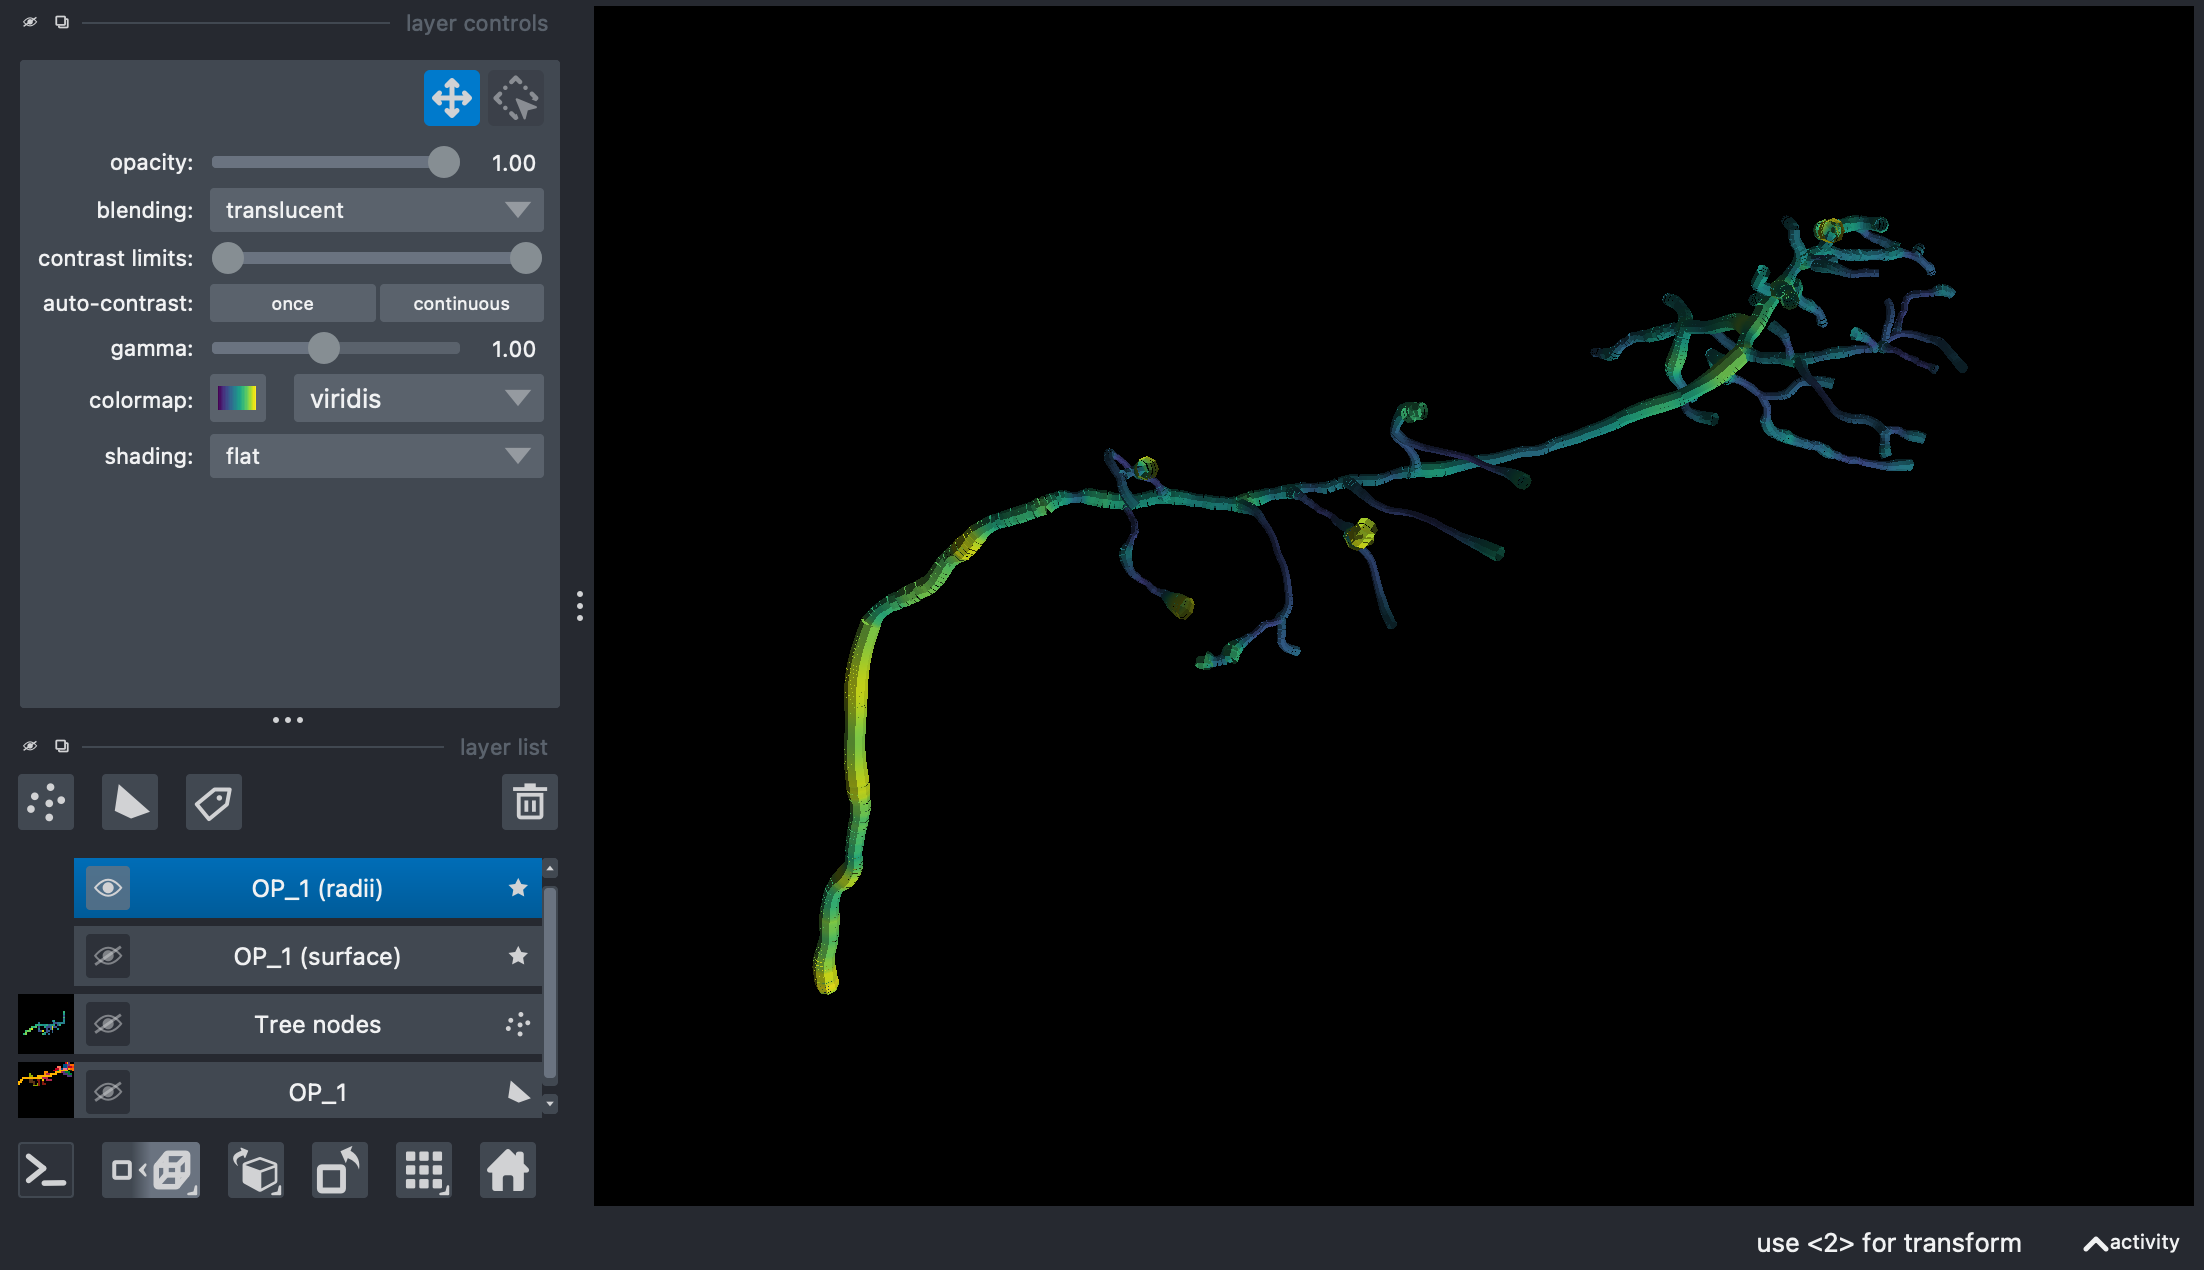

In [9]:
vertices, faces, radii = tree_to_surface(tree)
print(f"Vertices: {len(vertices)}, Faces: {len(faces)}, Values: {len(radii)}")

surface_layer2 = viewer.add_surface(
    (vertices, faces, radii),
    colormap='viridis',
    name=f'{tree.getLabel()} (radii)'
)

paths_layer.visible = False
nodes_layer.visible = False
surface_layer.visible = False

nbscreenshot(viewer)

## Mapping Measurements

As mentioned in [Tutorial 01](./01_single_cell_analysis.ipynb), we can 'overlay' measurements on the reconstruction itself, by means of a `ColorMapper` that maps quantitative traits to the Tree. We can modify the two functions we used so far to use the colors produced by {class}`TreeColorMapper <pysnt.analysis.TreeColorMapper>`:

In [10]:
def create_cylinder_mesh(p1, p2, r1, r2, c1, c2, n_segments=8):
    """Create a truncated cone mesh between two points with different radii and colors.
    
    Parameters
    ----------
    p1, p2 : array
        Start and end points (ZYX coordinates)
    r1, r2 : float
        Radii at start and end
    c1, c2 : tuple or array
        RGB(A) colors at start and end (values 0-1)
    """
    # Calculate direction vector
    direction = p2 - p1
    length = np.linalg.norm(direction)
    if length == 0:
        return None, None, None
    
    direction = direction / length
    
    # Create perpendicular vectors
    if abs(direction[2]) < 0.9:
        perp1 = np.cross(direction, [0, 0, 1])
    else:
        perp1 = np.cross(direction, [1, 0, 0])
    perp1 = perp1 / np.linalg.norm(perp1)
    perp2 = np.cross(direction, perp1)
    
    # Create circle vertices at both ends
    angles = np.linspace(0, 2*np.pi, n_segments, endpoint=False)
    vertices = []
    colors = []
    
    for i, (point, radius, color) in enumerate([(p1, r1, c1), (p2, r2, c2)]):
        for angle in angles:
            offset = radius * (np.cos(angle) * perp1 + np.sin(angle) * perp2)
            vertices.append(point + offset)
            colors.append(color)  # Assign color to this vertex
    
    vertices = np.array(vertices)
    colors = np.array(colors)
    
    # Create faces connecting the two circles
    faces = []
    for i in range(n_segments):
        next_i = (i + 1) % n_segments
        faces.append([i, next_i, i + n_segments])
        faces.append([next_i, next_i + n_segments, i + n_segments])
    
    return vertices, np.array(faces), colors


def snt_color_to_rgb(snt_color):
    """Convert Java Color to RGB tuple (0-1 range)."""
    if snt_color is None:
        return (0.5, 0.5, 0.5, 1)  # Default gray
    return (
        snt_color.getRed() / 255.0,
        snt_color.getGreen() / 255.0,
        snt_color.getBlue() / 255.0,
        snt_color.getAlpha() / 255.0
    )


def tree_to_surface(tree):
    """Convert SNT Tree to surface mesh using node colors."""
    all_vertices = []
    all_faces = []
    all_colors = []
    vertex_offset = 0
    
    for path in tree.list():
        for i in range(path.size() - 1):
            node1 = path.getNode(i)
            node2 = path.getNode(i + 1)
            
            p1 = np.array([node1.z, node1.y, node1.x])
            p2 = np.array([node2.z, node2.y, node2.x])
            r1 = node1.radius
            r2 = node2.radius
            
            # Extract colors from nodes
            c1 = snt_color_to_rgb(node1.getColor())
            c2 = snt_color_to_rgb(node2.getColor())
            
            verts, faces, colors = create_cylinder_mesh(p1, p2, r1, r2, c1, c2)
            if verts is not None:
                all_vertices.append(verts)
                all_faces.append(faces + vertex_offset)
                all_colors.append(colors)
                vertex_offset += len(verts)
    
    if not all_vertices:
        return None, None, None
    
    vertices = np.vstack(all_vertices)
    faces = np.vstack(all_faces)
    colors = np.vstack(all_colors)
    
    return vertices, faces, colors


[SNTUtils] Retrieving org.scijava.Context...

[INFO] [SNT] 116 scijava services loaded


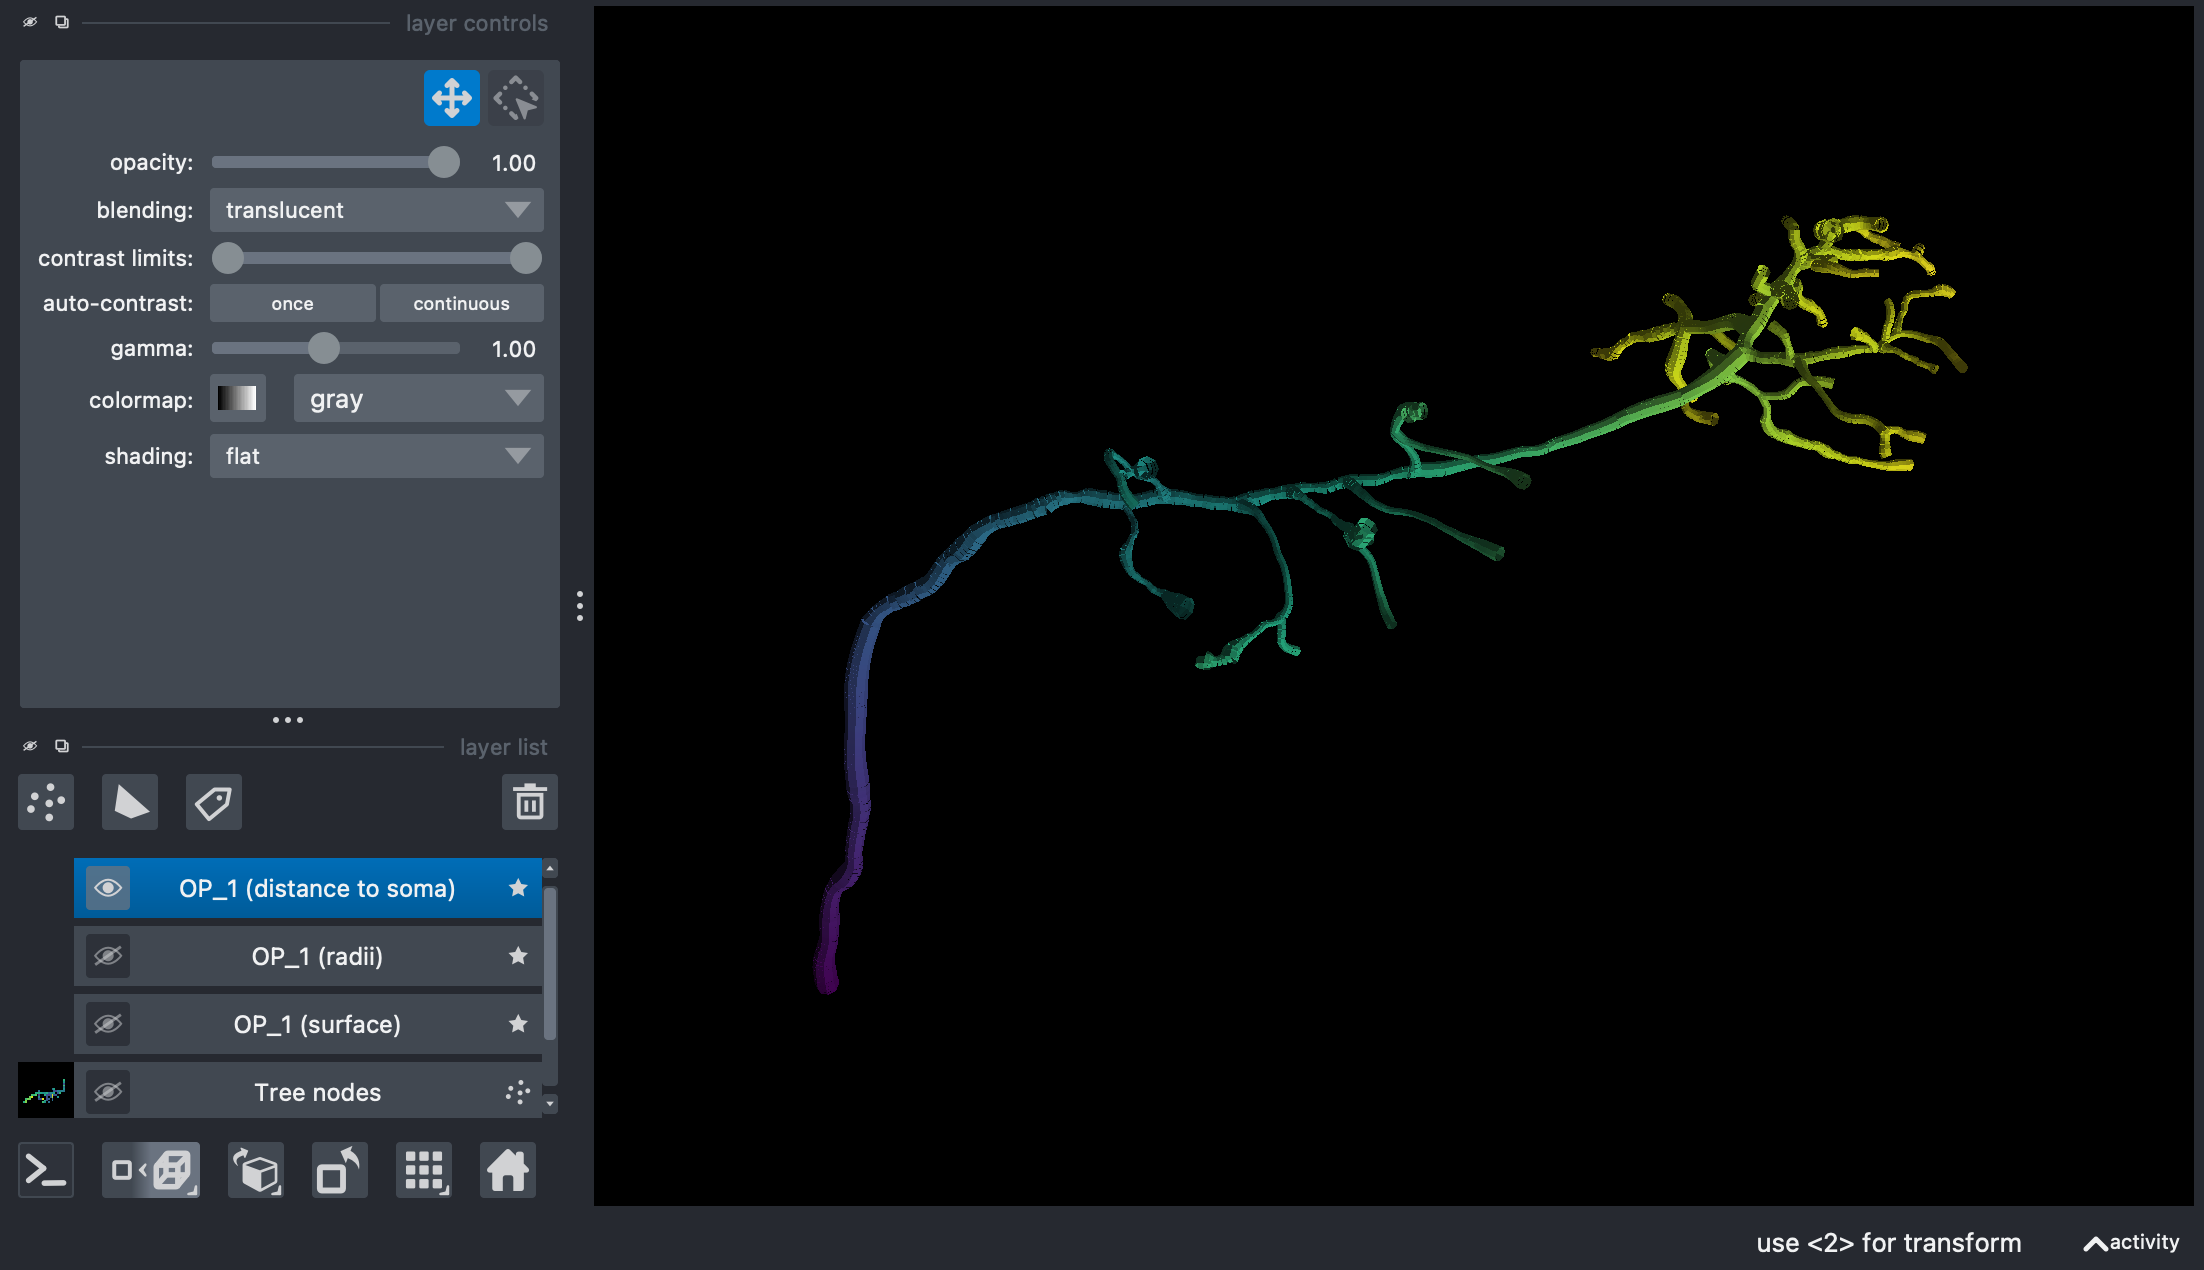

In [11]:
from pysnt.analysis import TreeColorMapper

# assign colors
color_mapper = TreeColorMapper()
metric = 'distance to soma'
color_mapper.map(tree, metric, 'viridis') # tree, metric, lut/colormap (case-sensitive)

# Create surface with just vertices and faces
vertices, faces, colors = tree_to_surface(tree)

surface_layer3 = viewer.add_surface(
    (vertices, faces),
    name=f'{tree.getLabel()} ({metric})'
)

# Set vertex colors directly on the layer
surface_layer3.vertex_colors = colors

surface_layer2.visible = False
nbscreenshot(viewer)

And, of course, we can adapt to any of the supported mappings:

In [12]:
# assign colors
print(color_mapper.getMetrics())

[Internode angle, Internode distance, No. of branch points, No. of nodes, No. of spines/varicosities, Node radius, Path spine/varicosity density, Path distance to soma, Path extension angle, Path extension angle (Rel.), Path extension angle XY, Path extension angle XZ, Path extension angle ZY, Path frame, Path length, Path mean radius, Path order, Sholl inters. (root centered), Horton-Strahler orders, Tags/filename, Node intensity values, X coordinates, Y coordinates, Z coordinates]


Creating a convenience function is probably the best strategy:

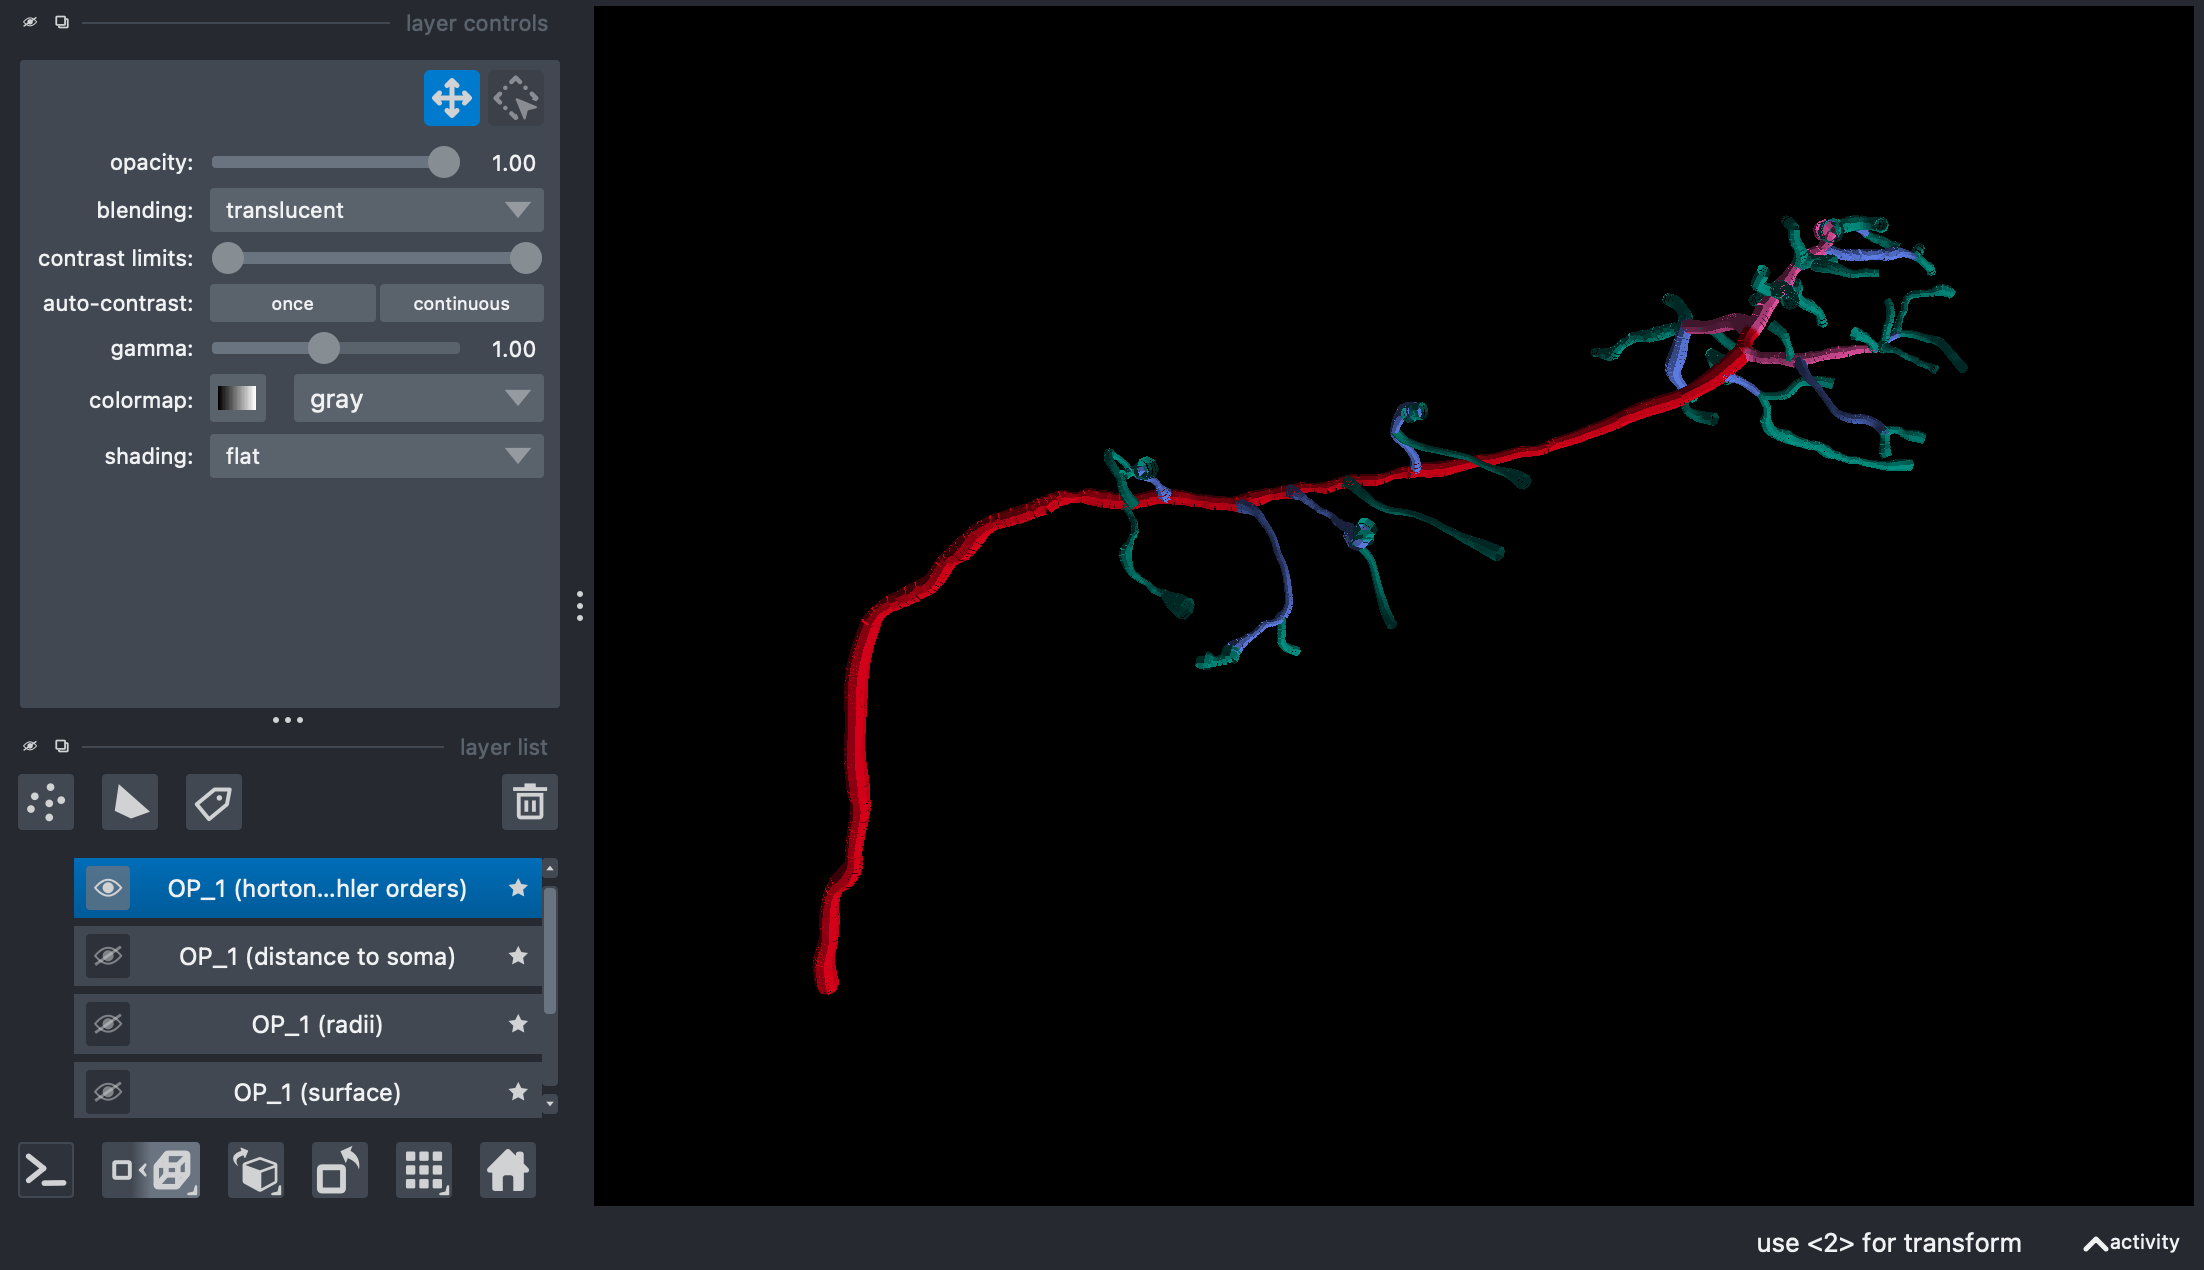

In [13]:
def color_mapped_surface(tree, metric, lut = 'ice'):
    from pysnt.analysis import TreeColorMapper
    color_mapper = TreeColorMapper()
    color_mapper.unMap(tree)
    color_mapper.map(tree, metric, 'ice') # tree, metric, LUT/colormap (NB: some LUTs are case-sensitive)

    # Create surface with just vertices and faces
    vertices, faces, colors = tree_to_surface(tree)

    surface_layer = viewer.add_surface(
        (vertices, faces),
        name=f'{tree.getLabel()} ({metric})'
    )

    # Set vertex colors directly on the layer
    surface_layer.vertex_colors = colors
    return surface_layer


surface_layer4 = color_mapped_surface(tree, 'horton-strahler orders', 'ice')
surface_layer3.visible = False
nbscreenshot(viewer)


## Loading Imagery

Most images generated by SNT are retrieved as ImageJ/Scijava images, either `ImagePlus` or `Dataset` objects. These can be converted to data arrays using pysnt's underlying pyimagej instance:

Operating in headless mode - the original ImageJ will have limited functionality.


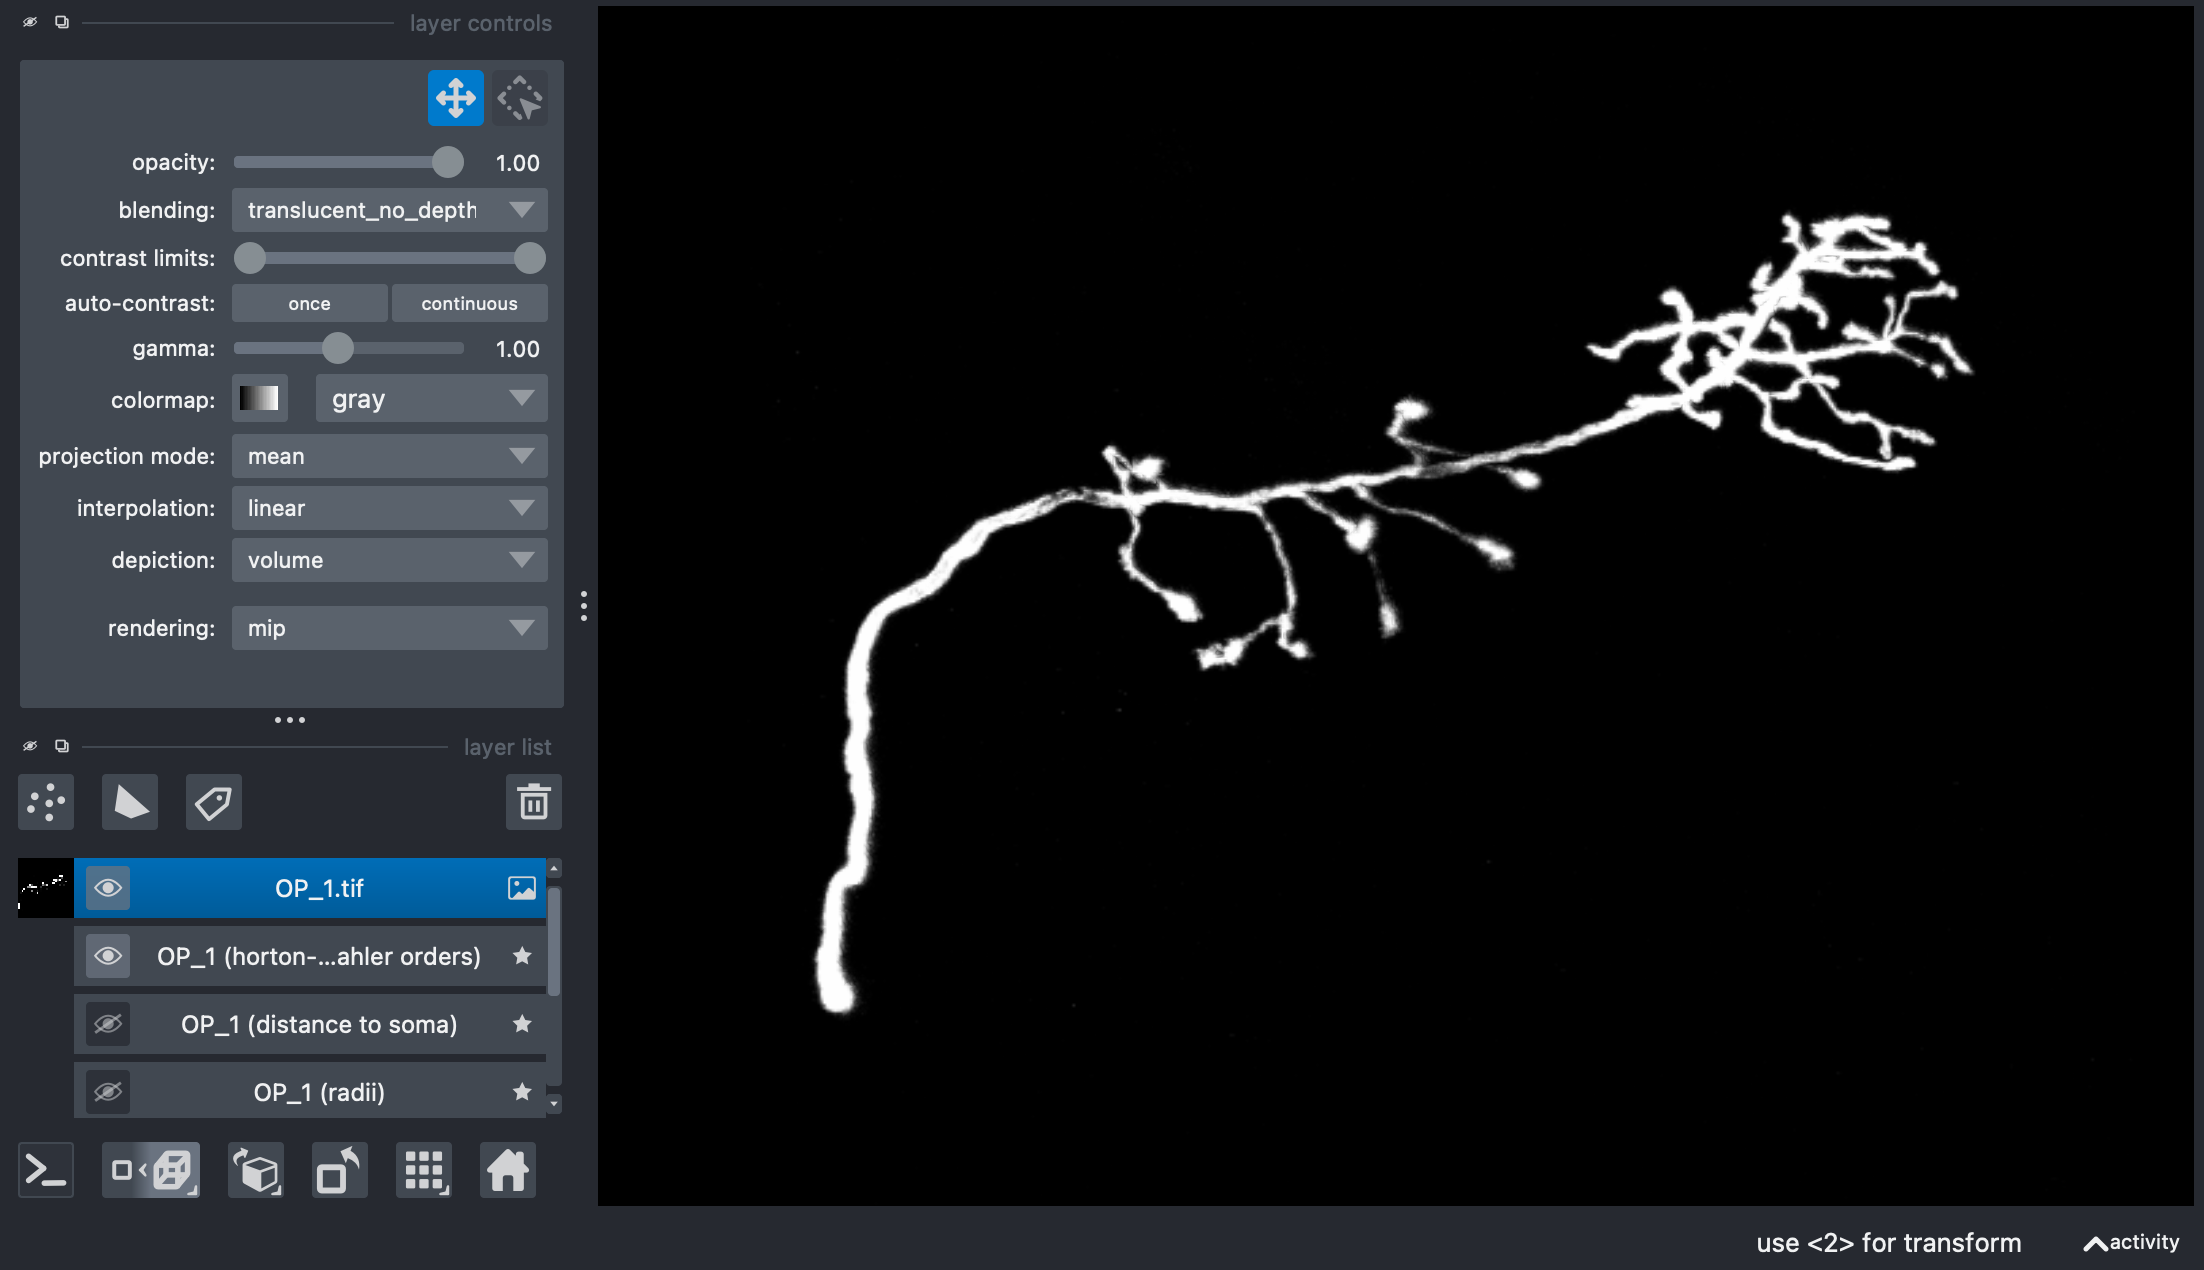

In [14]:
# Obtain demo image (ImagePlus object) associated
# with the OP1 reconstruction from pysnt.SNTService
img = snt_service.demoImage('OP1')
cal = img.getCalibration()

# Convert ImagePlus to xarray DataArray using pyimagej
image_xarray = pysnt.ij().py.from_java(img)

img_layer = viewer.add_image(
    image_xarray.values,
    name=img.getTitle(),
    rendering='mip',
    visible=True,
    colormap='gray',
    scale=(cal.pixelDepth, cal.pixelHeight, cal.pixelWidth)
)
nbscreenshot(viewer)

Now that the tutorial is complete, we can dispose of all resources:

In [ ]:
viewer.close() # Close napari
pysnt.dispose() # Dispose PySNT resources and shutdown the JVM

## Summary

In this tutorial, we demonstrated how to integrate PySNT with napari, to create interactive 3D visualizations of neuronal reconstructions. We explored multiple rendering strategies:

1. **Centerline visualization** using napari's Shapes layer to render paths as simple colored lines
2. **Node-based rendering** using Points layer to display individual reconstruction nodes as spheres, with sizes proportional to their radii
3. **Surface mesh rendering** by converting neuronal arbors into cylindrical meshes that represent local diameter variations more accurately
4. **Color-mapped visualizations** by integrating SNT's `TreeColorMapper` to overlay quantitative measurements (such as distance to soma or Strahler orders) onto 3D surface meshes
5. **Image overlay** by converting ImageJ/Fiji images to numpy arrays for simultaneous visualization of reconstructions alongside their source 



## Data Sources and References

Data used in this notebook is part of SNT's demo datasets. In particular, the *OP_1* [dataset](https://diadem.janelia.org/olfactory_projection_fibers_readme.html). The relevant publications associated with this dataset are:

- Brown KM, Barrionuevo G, Canty AJ, et al. The DIADEM data sets: representative light microscopy images of neuronal morphology to advance automation of digital reconstructions. Neuroinformatics. 2011;9(2-3):143-157. doi:[10.1007/s12021-010-9095-5](https://doi.org/10.1007/s12021-010-9095-5)

- Jefferis GS, Potter CJ, Chan AM, et al. Comprehensive maps of Drosophila higher olfactory centers: spatially segregated fruit and pheromone representation. Cell. 2007;128(6):1187-1203. doi:[10.1016/j.cell.2007.01.040](https://doi.org/10.1016/j.cell.2007.01.040)

See [SNT citation](https://imagej.net/plugins/snt/faq#how-do-i-cite-snt) for details on how to properly cite SNT.